In [1]:
import numpy as np
import torch
from torch.utils import data
import sys
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
sys.path.append("../hyperLAI/")
sys.path.append("../../libraries/")
from utils.generate_dataset import *
from torch.utils.data import DataLoader
from HypHC.model.hyphc import HypHC as hyphc_obj
from HypHC.utils.poincare import project
from HypHC.utils.visualization import plot_tree_from_leaves
from HypHC.utils.metrics import dasgupta_cost
from HypHC.optim.radam import RAdam
from HypHC.datasets.triples import samples_triples
import itertools

In [2]:
vcf_path = "/scratch/users/patelas/hyperLAI/snp_data/ref_final_beagle_phased_1kg_hgdp_sgdp_chr1_hg19.vcf.gz"
tsv_path = "/scratch/users/patelas/hyperLAI/snp_data/reference_panel_metadata.tsv"                    
output_path = "./"                  


In [14]:
class SimpleModelLoader(data.Dataset):
    def __init__(self, vcf_path, tsv_path, output_path, similarity_func, 
                 restrict_labels=[0,1,2,3,4,5,6], sample_size=100, num_triples=1e6, chromosome=22):
        '''
        Takes in all the relevant arguments to produce the dataset.
        Arguments:
            `vcf_path`: path to relevant vcf file containing the snp data
            `tsv_path`: path to tsv file containing data labels
            `similarity_func`: function to calculate pairwise similarities
            `restrict_labels`: list of super-populations to include in analysis. Indices correspond to 'EUR', 'EAS', 'AMR', 'SAS', 'AFR', 'OCE', 'WAS'
            `sample_size`: number of individuals to include in the dataset produced
            `num_triples`: number of triples of individuals to include in training (can be any number)
            `chromosome`: chromosome to take SNPs from. make sure this matches the vcf_path file.
                If "all" instead of a number, will draw all chromosomes from a premade data file in a specific location 
        '''

        self.vcf_path = vcf_path
        self.tsv_path = tsv_path
        self.output_path = output_path
        self.sim_func = similarity_func
        self.restrict_labels=restrict_labels
        self.sample_size=sample_size
        self.num_triples=num_triples
        self.chromosome=chromosome
        self.snps, self.pop_labels, self.suppop_labels, self.pop_label_index, self.suppop_label_index = self.load_data()
        self.sim_mat = self.make_pairwise_similarities()
        self.triples = self.produce_triples()
    def load_data(self):
        '''
        Loads SNP and label data from the necessary file locations 
        '''
        #If we want all chromosomes, then we have the arrays already pre-created
        if self.chromosome == "all":
            file_order = ["all_snps.npy", "labels_suppop.npy", "labels_pop.npy", 
                          "coords.npy", "pop_index.npy", "pop_code_index.npy", "suppop_code_index.npy"]
            test_data = tuple([np.load("/scratch/users/patelas/hyperLAI/snp_data/whole_genome/variance_filtered_500000/" + x) for x in file_order])
            ind_data = test_data[0]
        #Else, we use the dataset loading script with this chromosome
        else:
            test_data = load_dataset(self.vcf_path, self.tsv_path, self.output_path, chromosome=self.chromosome, 
                                 verbose=True, filter_admixed=True, filter_missing_coord=True)
            ind_data = test_data[0].reshape([test_data[0].shape[0], test_data[0].shape[1] * test_data[0].shape[2]]).T
        #In both cases, we've unfolded each set of 23 chromosomes as a "different" individual 
        #So we must do the same for the labels by doubling them
        ind_pop_labels = np.repeat(test_data[2], 2).astype(int)
        ind_suppop_labels = np.repeat(test_data[1], 2).astype(int)
        #Restrict to only the super-populations we've specified
        indices = np.argwhere(np.isin(ind_suppop_labels, self.restrict_labels)).T[0]
        #Sample the required number of individuals
        indices = np.random.choice(indices, size=self.sample_size, replace=False)
        ind_data = ind_data[indices]
        #Return everything
        return ind_data, ind_pop_labels[indices], ind_suppop_labels[indices], test_data[4], test_data[6]
    def make_pairwise_similarities(self):
        '''
        Creates a similarity matrix from the SNP data using the specified similarity function
        '''
        sim_matrix = np.zeros((self.snps.shape[0], self.snps.shape[0]))
        #Fill in matrix
        for ind in range(self.snps.shape[0]):
            for ind2 in range(self.snps.shape[0]):
                sim_matrix[ind][ind2] = self.sim_func(self.snps[ind], self.snps[ind2])
        #Divide by maximum for normalization
        sim_matrix /= np.amax(sim_matrix)
        return sim_matrix
    def produce_triples(self):
        '''
        Returns an array with randomly selected indices of combinations of 3 "individuals"
        See the samples_triples function for how it works
        (If num_triples is sufficiently high, it ensure all individuals are seen)
        '''
        return samples_triples(len(self.snps), self.num_triples)
    def __len__(self):
        return len(self.triples)
    def __getitem__(self, index):
        '''
        Returns triple and similarity for the current index
        '''
        #Get the three "individuals" in that triple
        curr_triple = self.triples[index]
        #Create a list of the similarities
        sims = [self.sim_mat[curr_triple[0], curr_triple[1]], 
                self.sim_mat[curr_triple[0], curr_triple[2]], 
                self.sim_mat[curr_triple[1], curr_triple[2]]]
        return torch.tensor(curr_triple), torch.tensor(sims)
            
    


In [15]:
def train_hyphc_model(dataset, rank, temperature, lr, epochs, batch_size, 
                      anneal_every=None, anneal_factor=0.5, patience=5):
    
    '''
    Trains the simple embedding model
    Arguments:
        `dataset`: a SimpleModelLoader instance
        `rank`: number of dimensions of embedding
        `temperature`: temperature value (for temperature scaling)
        `lr`: learning rate
        `epochs`: max number of epochs (will save best model)
        `batch_size`: batch size
        `anneal_every`: perform annealing every x epochs (default is no annealing)
        `anneal_factor`: factor to anneal by
        `patience`: patience for early lstopping 
    '''
    #Create data loader
    dloader = DataLoader(dataset, batch_size=batch_size)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    #Define model and optimizer with relevant hyperparams
    model = hyphc_obj(len(dataset.snps), rank=rank, temperature=temperature).to(device)
    optimizer = RAdam(model.parameters(), lr=lr)
    best_model, best_cost, best_epoch = None, None, None
    #Train each epoch
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for step, (triple_ids, triple_similarities) in enumerate(dloader):
            if step % 500 == 0:
                print(step)
            triple_ids = triple_ids.to(device)
            triple_similarities = triple_similarities.to(device)
            loss = model.loss(triple_ids, triple_similarities)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss
        total_loss = total_loss.item() / (step + 1.0)
        model.eval()
        #Decode tree for evaluation, and calculate Dasgupta's cost
        tree = model.decode_tree(fast_decoding=True)
        cost = dasgupta_cost(tree, dataset.sim_mat)
        print("{}:\t{:.4f}".format("Dasgupta's cost", cost))
        #We use Dasgupta's cost to define the best model
        if best_cost is None or cost < best_cost:
            counter=0
            best_model = model
            best_cost = cost
            best_epoch = epoch + 1   
            
        else:
            counter += 1
            if counter == patience:
                print("Early stopping.")
                break
        #Anneal if called for
        if anneal_every is not None and (epoch + 1) % anneal_every == 0:
            model.anneal_temperature(anneal_factor)
            print("Annealing temperature to: {}".format(model.temperature))
            for param_group in optimizer.param_groups:
                param_group['lr'] *= anneal_factor
                lr = param_group['lr']
            print("Annealing learning rate to: {}".format(lr))
        
        print("\t Epoch {} | average train loss: {:.6f}".format(epoch, total_loss))
    return best_model, best_cost, best_epoch

    
    
    

In [16]:
def plot_weights_pca(model, labels, annotations=None):
    '''
    Plot PCA of embedding
    Note: if the embedding is two-dimensional, can alter this to just plot the embeddings
    '''
    weights = model.embeddings.weight.data.detach().cpu()
    weights_pca = PCA().fit_transform(weights)
    scplot = sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,1], hue=labels)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA of Embedding Weights")
    if annotations is not None:
        for line in range(len(labels)):
            if weights_pca[line,1] < 0.5:
                continue
            scplot.text(weights_pca[line,0]+0.005, weights_pca[line,1], 
                         annotations[line], horizontalalignment='left', color='black', size=8)

#     plt.show()    


In [17]:
#Dataset for all populations
small_dataset = SimpleModelLoader(vcf_path, tsv_path, output_path, lambda x,y: (np.sum(x==y)) / len(x), chromosome="all")


Generating all pairs superset


In [ ]:
#Continental datasets

# afr_dataset = SimpleModelLoader(vcf_path, tsv_path, output_path, lambda x,y: (np.sum(x==y)) / len(x), [4])
eur_dataset = SimpleModelLoader(vcf_path, tsv_path, output_path, lambda x,y: (np.sum(x==y)) / len(x), [0])
# sas_dataset = SimpleModelLoader(vcf_path, tsv_path, output_path, lambda x,y: (np.sum(x==y)) / len(x), [3])
# was_dataset = SimpleModelLoader(vcf_path, tsv_path, output_path, lambda x,y: (np.sum(x==y)) / len(x), [6])
# amr_dataset = SimpleModelLoader(vcf_path, tsv_path, output_path, lambda x,y: (np.sum(x==y)) / len(x), [2])

In [ ]:
model_negfour_hlr, loss_negfour_hlr, epoch_negfour_hlr = train_hyphc_model(dataset=small_dataset, rank=10, 
                                                temperature=0.0001, lr=1e-2, epochs=15, batch_size=512)

In [26]:
model_negthree, loss_negthree, epoch_negthree = train_hyphc_model(dataset=small_dataset, rank=10, 
                                                temperature=0.001, lr=1e-3, epochs=25, batch_size=512, patience=7)

0
500
1000
1500
Dasgupta's cost:	596945.7976
	 Epoch 0 | average train loss: 1.792055
0
500
1000
1500
Dasgupta's cost:	596934.8597
	 Epoch 1 | average train loss: 1.792007
0
500
1000
1500
Dasgupta's cost:	596944.6461
	 Epoch 2 | average train loss: 1.791990
0
500
1000
1500
Dasgupta's cost:	596934.6516
	 Epoch 3 | average train loss: 1.791993
0
500
1000
1500
Dasgupta's cost:	596936.6793
	 Epoch 4 | average train loss: 1.791978
0
500
1000
1500
Dasgupta's cost:	596930.9824
	 Epoch 5 | average train loss: 1.791970
0
500
1000
1500
Dasgupta's cost:	596931.7762
	 Epoch 6 | average train loss: 1.791954
0
500
1000
1500
Dasgupta's cost:	596932.7387
	 Epoch 7 | average train loss: 1.791968
0
500
1000
1500
Dasgupta's cost:	596937.4835
	 Epoch 8 | average train loss: 1.791955
0
500
1000
1500
Dasgupta's cost:	596933.1059
	 Epoch 9 | average train loss: 1.791960
0
500
1000
1500
Dasgupta's cost:	596930.7850
	 Epoch 10 | average train loss: 1.791945
0
500
1000
1500
Dasgupta's cost:	596932.5158
	 Epoch 

In [ ]:
model_negthree_hlr, loss_negthree_hlr, epoch_negthree_hlr = train_hyphc_model(dataset=small_dataset, rank=10, 
                                                temperature=0.001, lr=1e-2, epochs=25, batch_size=512, patience=7)

0
500
1000
1500
Dasgupta's cost:	327969.7284
	 Epoch 0 | average train loss: 0.988840
0
500
1000
1500
Dasgupta's cost:	327972.7384
	 Epoch 1 | average train loss: 0.988717
0
500
1000
1500
Dasgupta's cost:	327959.4809
	 Epoch 2 | average train loss: 0.988628
0
500
1000
1500
Dasgupta's cost:	327969.3931
	 Epoch 3 | average train loss: 0.988435
0
500
1000
1500
Dasgupta's cost:	327988.0603
	 Epoch 4 | average train loss: 0.988464
0
500
1000
1500
Dasgupta's cost:	327965.9454
	 Epoch 5 | average train loss: 0.988409
0
500
1000
1500
Dasgupta's cost:	327973.0253
	 Epoch 6 | average train loss: 0.988442
0
500
1000
1500
Dasgupta's cost:	327955.4357
	 Epoch 7 | average train loss: 0.988323
0
500
1000
1500
Dasgupta's cost:	327977.2854
	 Epoch 8 | average train loss: 0.988312
0
500
1000
1500
Dasgupta's cost:	327967.4740
	 Epoch 9 | average train loss: 0.988331
0
500
1000
1500
Dasgupta's cost:	328229.0552
	 Epoch 10 | average train loss: 0.988319
0
500
1000
1500
Dasgupta's cost:	328215.5679
	 Epoch 

In [28]:
model_fivenegfour, loss_fivenegfour, epoch_fivenegfour = train_hyphc_model(dataset=small_dataset, rank=10, 
                                                temperature=0.0005, lr=1e-3, epochs=25, batch_size=512, patience=7)

0
500
1000
1500
Dasgupta's cost:	596940.6702
	 Epoch 0 | average train loss: 1.791914
0
500
1000
1500
Dasgupta's cost:	596931.5337
	 Epoch 1 | average train loss: 1.791816
0
500
1000
1500
Dasgupta's cost:	596930.9088
	 Epoch 2 | average train loss: 1.791810
0
500
1000
1500
Dasgupta's cost:	596928.1777
	 Epoch 3 | average train loss: 1.791797
0
500
1000
1500
Dasgupta's cost:	596927.3698
	 Epoch 4 | average train loss: 1.791775
0
500
1000
1500
Dasgupta's cost:	596928.1919
	 Epoch 5 | average train loss: 1.791777
0
500
1000
1500
Dasgupta's cost:	596936.7862
	 Epoch 6 | average train loss: 1.791764
0
500
1000
1500
Dasgupta's cost:	596930.3923
	 Epoch 7 | average train loss: 1.791775
0
500
1000
1500
Dasgupta's cost:	596928.1116
	 Epoch 8 | average train loss: 1.791747
0
500
1000
1500
Dasgupta's cost:	596928.4485
	 Epoch 9 | average train loss: 1.791767
0
500
1000
1500
Dasgupta's cost:	596927.2131
	 Epoch 10 | average train loss: 1.791757
0
500
1000
1500
Dasgupta's cost:	596927.3373
	 Epoch 

In [23]:
model_fivenegfour_hlr, loss_fivenegfour_hlr, epoch_fivenegfour_hlr = train_hyphc_model(dataset=small_dataset, rank=10, 
                                                temperature=0.0005, lr=1e-2, epochs=25, batch_size=512, patience=7)

0
500
1000
1500
Dasgupta's cost:	596928.9706
	 Epoch 0 | average train loss: 1.791906
0
500
1000
1500
Dasgupta's cost:	596940.7672
	 Epoch 1 | average train loss: 1.791815
0
500
1000
1500
Dasgupta's cost:	596934.6718
	 Epoch 2 | average train loss: 1.791801
0
500
1000
1500
Dasgupta's cost:	596930.5324
	 Epoch 3 | average train loss: 1.791770
0
500
1000
1500
Dasgupta's cost:	596931.3295
	 Epoch 4 | average train loss: 1.791772
0
500
1000
1500
Dasgupta's cost:	596929.0090
	 Epoch 5 | average train loss: 1.791763
0
500
1000
1500
Dasgupta's cost:	596914.1332
	 Epoch 6 | average train loss: 1.791757
0
500
1000
1500
Dasgupta's cost:	596914.3753
	 Epoch 7 | average train loss: 1.791742
0
500
1000
1500
Dasgupta's cost:	596928.7772
	 Epoch 8 | average train loss: 1.791751
0
500
1000
1500
Dasgupta's cost:	596931.1204
	 Epoch 9 | average train loss: 1.791736
0
500
1000
1500
Dasgupta's cost:	596916.9236
	 Epoch 10 | average train loss: 1.791721
0
500
1000
1500
Dasgupta's cost:	596930.5716
	 Epoch 

In [ ]:
model_afr, loss_afr, epoch_afr = train_hyphc_model(dataset=afr_dataset, rank=10, 
                                                temperature=0.001, lr=1e-2, epochs=15, batch_size=512)

In [ ]:
model_eur, loss_eur, epoch_eur = train_hyphc_model(dataset=eur_dataset, rank=10, 
                                                temperature=0.001, lr=1e-2, epochs=25, batch_size=512)

In [ ]:
model_sas, loss_sas, epoch_sas = train_hyphc_model(dataset=sas_dataset, rank=10, 
                                                temperature=0.001, lr=1e-2, epochs=15, batch_size=512)

In [ ]:
model_was, loss_was, epoch_was = train_hyphc_model(dataset=was_dataset, rank=10, 
                                                temperature=0.001, lr=1e-2, epochs=15, batch_size=512)

In [ ]:
model_amr, loss_amr, epoch_amr = train_hyphc_model(dataset=amr_dataset, rank=10, 
                                                temperature=0.0000001, lr=1e-3, epochs=15, batch_size=512)

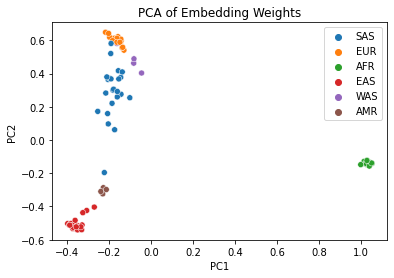

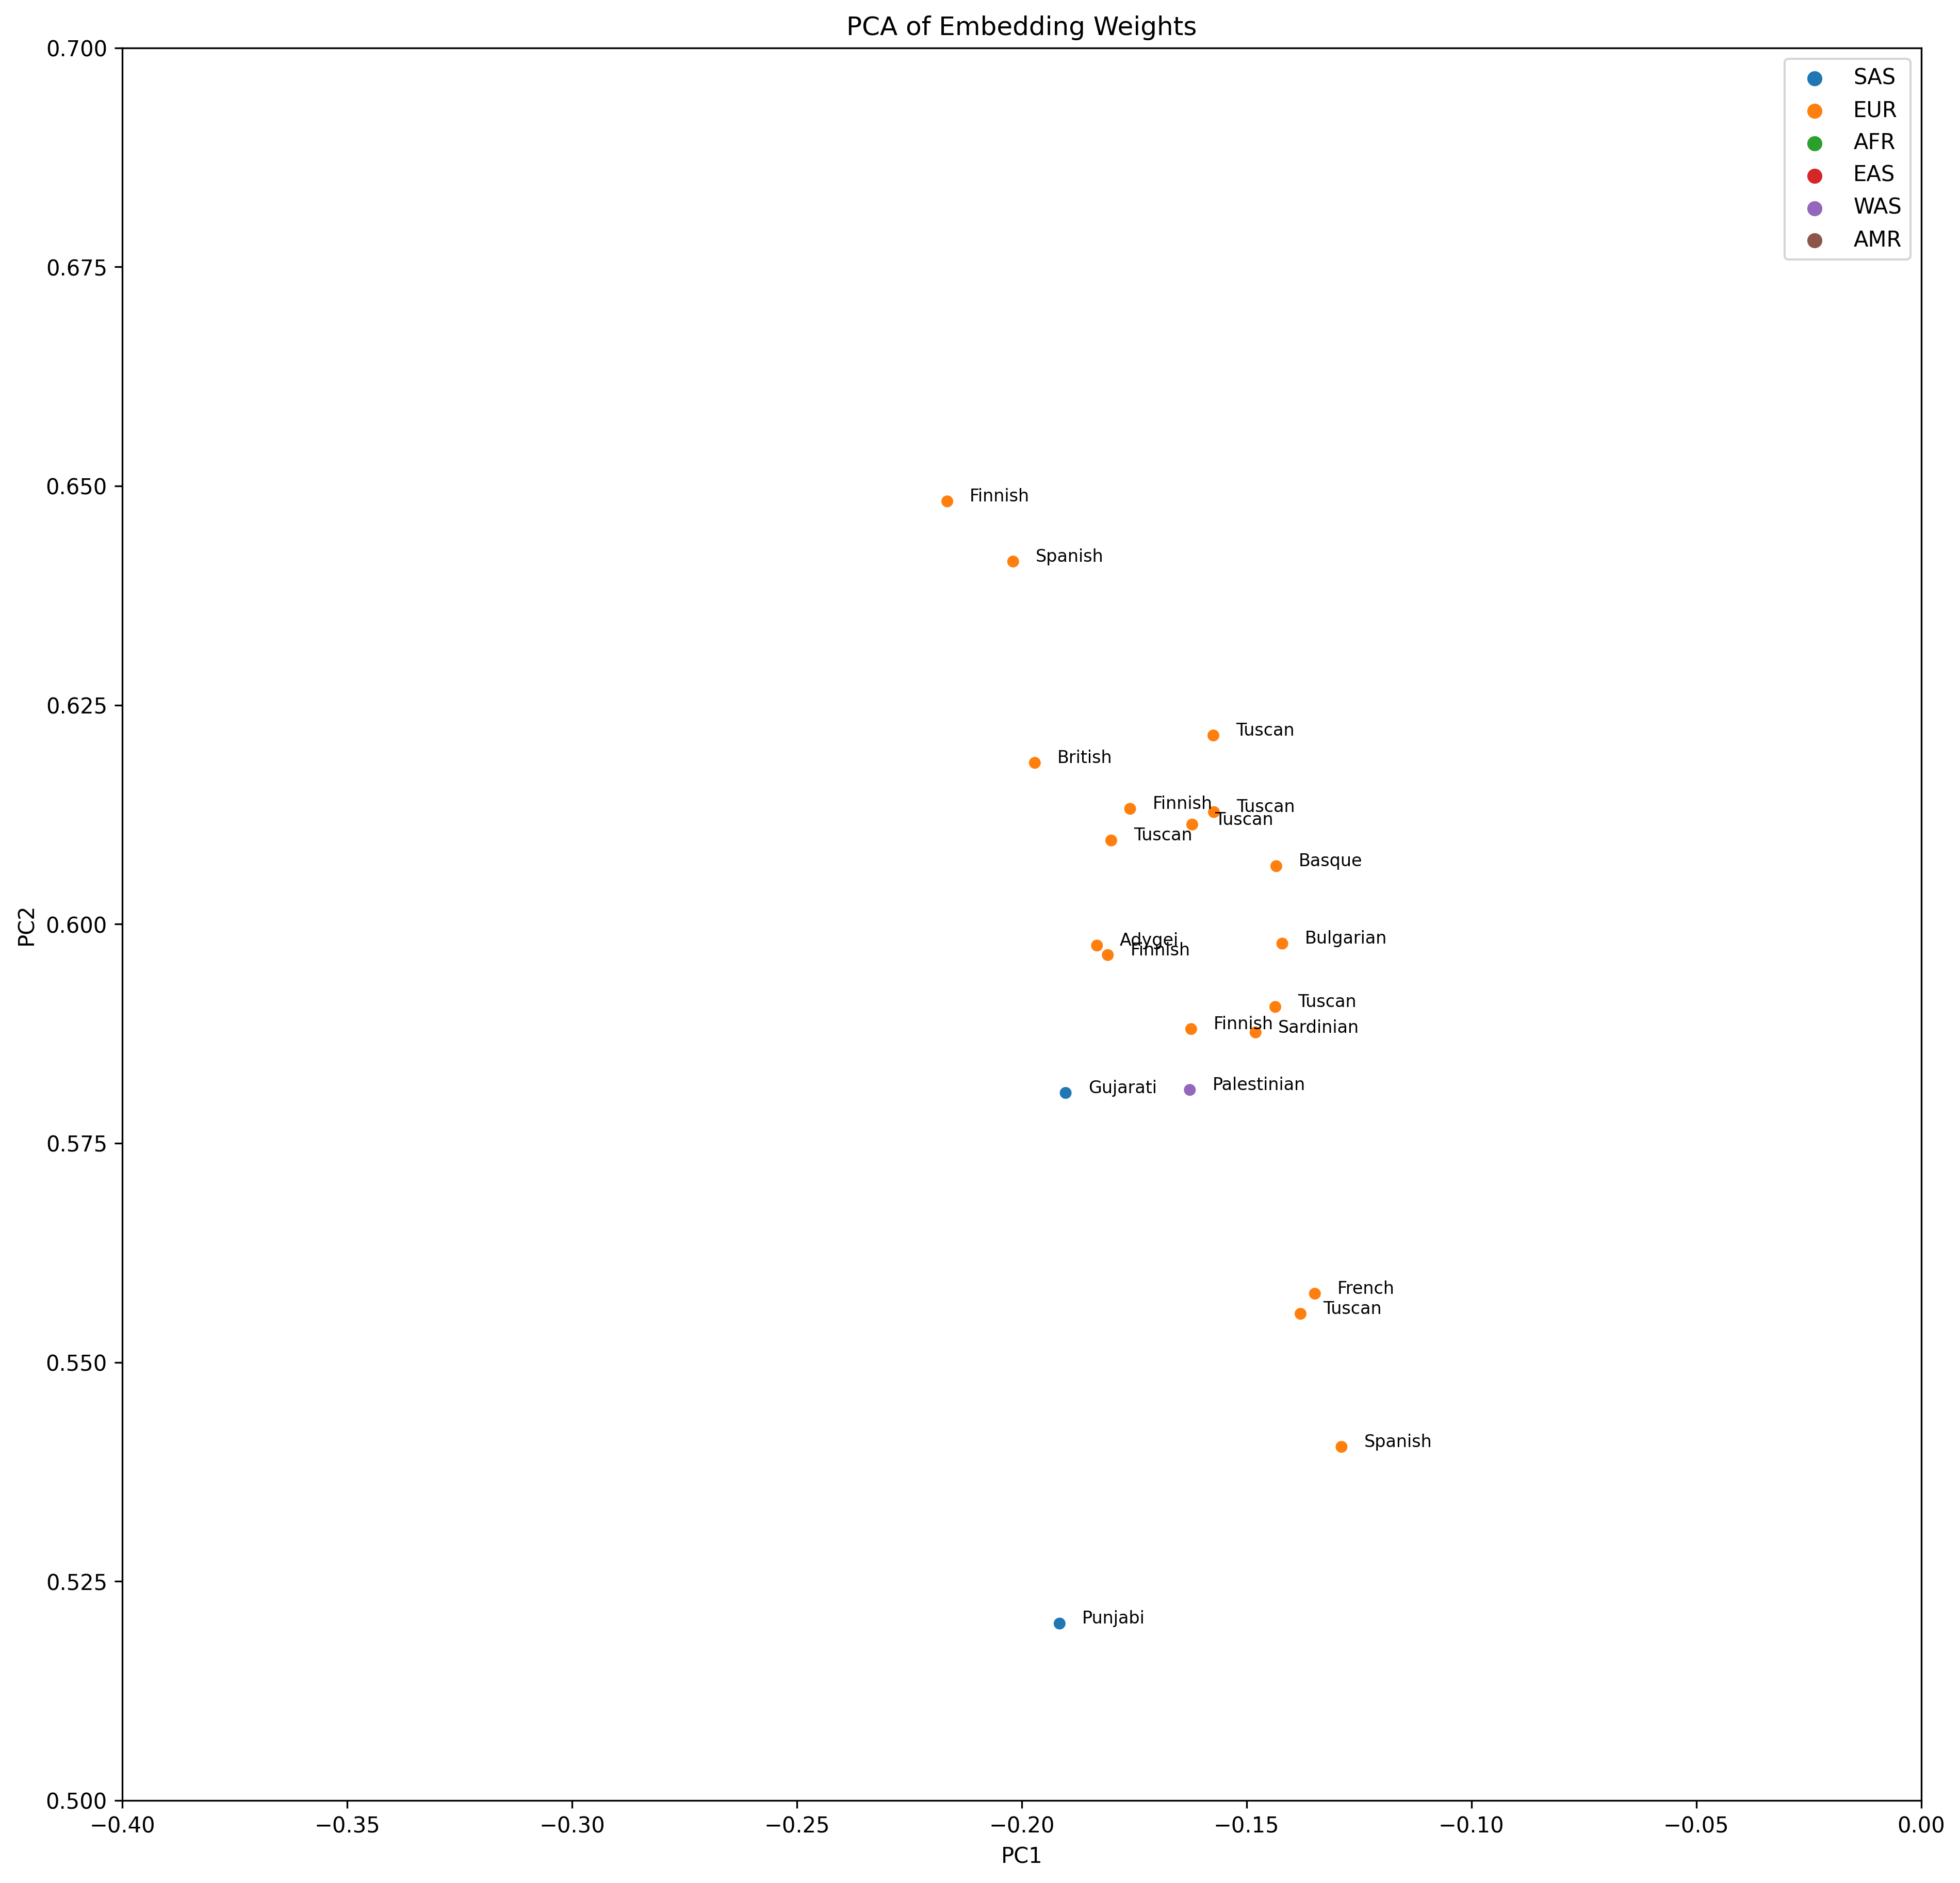

In [20]:
suppop_labels = [small_dataset.suppop_label_index[x] for x in small_dataset.suppop_labels]
pop_labels = [small_dataset.pop_label_index[x] for x in small_dataset.pop_labels]
# plot_weights_pca(model_negfour_hlr, suppop_labels)
# plt.show()
# plot_weights_pca(model_fivenegfour_hlr, suppop_labels)
# plt.show()
plot_weights_pca(model_negthree_hlr, suppop_labels)
plt.show()
plt.figure(figsize=[15,15], dpi=300)
plot_weights_pca(model_negthree_hlr, suppop_labels, pop_labels)
plt.xlim(-0.4,0)
plt.ylim(0.5, 0.7)
plt.show()
# plot_weights_pca(model_fivenegthree_hlr, suppop_labels)
# plt.show()


# Unit Tests

In [1]:
import unittest

In [4]:
vcf_path = "/scratch/users/patelas/hyperLAI/snp_data/ref_final_beagle_phased_1kg_hgdp_sgdp_chr22_hg19.vcf.gz"
tsv_path = "/scratch/users/patelas/hyperLAI/snp_data/reference_panel_metadata.tsv"                    
output_path = "./"                  


In [5]:
small_dataset = SimpleModelLoader(vcf_path, tsv_path, output_path, lambda x,y: (np.sum(x==y)) / len(x), chromosome=22)


start reading ...
File read: 317408 SNPs for 3558 individuals
done loading vcf... Shape of vcf file is :  (317408, 3558, 2) Shape of vcf names file is (3558,)
TSV loaded Index(['Sample', 'Population code', 'Population', 'Superpopulation code',
       'Superpopulation', 'Source', 'Latitude', 'Longitude', 'Region',
       'Sample Alias', 'Country', 'Town', 'Single_Ancestry'],
      dtype='object') DF shape is  (3558, 13)
Super population code are ,  ['EUR', 'EAS', 'AMR', 'SAS', 'AFR', 'OCE', 'WAS'] 7
Population code are ,  ['GBR', 'FIN', 'CHS', 'PUR', 'CDX', 'CLM', 'IBS', 'PEL', 'PJL', 'KHV', 'ACB', 'GWD', 'ESN', 'BEB', 'MSL', 'STU', 'ITU', 'CEU', 'YRI', 'CHB', 'JPT', 'LWK', 'ASW', 'MXL', 'TSI', 'GIH', nan] 27
Population names are ,  ['British', 'Finnish', 'Southern Han Chinese', 'Puerto Rican', 'Dai Chinese', 'Colombian', 'Spanish', 'Peruvian', 'Punjabi', 'Kinh Vietnamese', 'African-Caribbean', 'Gambian Mandinka', 'Esan', 'Bengali', 'Mende', 'Sri Lankan', 'Indian Telugu', 'CEPH', 'Yorub

In [12]:
class TestSimpleLoader(unittest.TestCase):
    #Note - loading in the data is tested with the fully connected model since it's the same
    def test_similarity(self):
        '''
        Tests that the similarity function works correctly
        Takes two random data points (54 and 78), calculates their similarity
        And ensures both relevant spots in the similarity matrix have the right value
        '''
        sim_func = lambda x,y: (np.sum(x==y)) / len(x)
        sim_first = small_dataset.sim_mat[78, 54]
        sim_second = small_dataset.sim_mat[54, 78]
        sim_verify = sim_func(small_dataset.snps[54], small_dataset.snps[78])
        self.assertEqual(sim_verify, sim_first)
        self.assertEqual(sim_verify, sim_second)
    def test_correct_num_triples(self):
        '''
        Ensures we have produced the correct number of triples
        '''
        self.assertEqual(len(small_dataset.triples), 1e6)
    def test_item_retrieval(self):
        '''
        Tests that the similarities provided when indexing the dataset are indeed the desired ones
        '''
        random_item = small_dataset[85]
        triples = random_item[0]
        self.assertEqual(random_item[1][0], small_dataset.sim_mat[triples[0], triples[1]])
        self.assertEqual(random_item[1][1], small_dataset.sim_mat[triples[0], triples[2]])
        self.assertEqual(random_item[1][2], small_dataset.sim_mat[triples[1], triples[2]])
    

In [13]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)


...
----------------------------------------------------------------------
Ran 3 tests in 34.399s

OK


Everything after this can be ignored

In [ ]:
suppop_labels = [afr_dataset.suppop_label_index[x] for x in afr_dataset.suppop_labels]
pop_labels = [afr_dataset.pop_label_index[x] for x in afr_dataset.pop_labels]
plt.figure(figsize=[15,15], dpi=300)
plot_weights_pca(model_afr, suppop_labels, pop_labels)
plt.show()

In [ ]:
suppop_labels = [eur_dataset.suppop_label_index[x] for x in eur_dataset.suppop_labels]
pop_labels = [eur_dataset.pop_label_index[x] for x in eur_dataset.pop_labels]
plt.figure(figsize=[15,15], dpi=300)
plot_weights_pca(model_eur, suppop_labels, pop_labels)
plt.show()

In [ ]:
suppop_labels = [sas_dataset.suppop_label_index[x] for x in sas_dataset.suppop_labels]
pop_labels = [sas_dataset.pop_label_index[x] for x in sas_dataset.pop_labels]
plt.figure(figsize=[15,15], dpi=300)
plot_weights_pca(model_sas, suppop_labels, pop_labels)
plt.show()

In [ ]:
suppop_labels = [sas_dataset.suppop_label_index[x] for x in sas_dataset.suppop_labels]
pop_labels = [sas_dataset.pop_label_index[x] for x in sas_dataset.pop_labels]
plt.figure(figsize=[15,15], dpi=300)
plot_weights_pca(model_sas_lowt, suppop_labels, pop_labels)
plt.show()

In [ ]:
suppop_labels = [was_dataset.suppop_label_index[x] for x in was_dataset.suppop_labels]
pop_labels = [was_dataset.pop_label_index[x] for x in was_dataset.pop_labels]
plt.figure(figsize=[15,15], dpi=300)
plot_weights_pca(model_was, suppop_labels, pop_labels)
plt.show()

In [ ]:
suppop_labels = [amr_dataset.suppop_label_index[x] for x in amr_dataset.suppop_labels]
pop_labels = [amr_dataset.pop_label_index[x] for x in amr_dataset.pop_labels]
plt.figure(figsize=[15,15], dpi=300)
plot_weights_pca(model_was, suppop_labels, pop_labels)
plt.show()

In [ ]:
epoch_negfour_hlr

In [ ]:
model = hyphc_obj(len(small_dataset.snps), rank=10, temperature=0.0001).to(device)

In [ ]:
epochs=10
# optimizer = torch.optim.Adam(model.parameters())
optimizer = RAdam(model.parameters(), lr=5e-4)


In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for step, (triple_ids, triple_similarities) in enumerate(dloader):
        if step % 500 == 0:
            print(step)
        triple_ids = triple_ids.to(device)
        triple_similarities = triple_similarities.to(device)
        loss = model.loss(triple_ids, triple_similarities)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
    total_loss = total_loss.item() / (step + 1.0)
    print("\t Epoch {} | average train loss: {:.6f}".format(epoch, total_loss))


In [ ]:
sns.scatterplot(x=model.embeddings.weight.detach().cpu()[:,0], y=model.embeddings.weight.detach().cpu()[:,1],
               hue=[small_dataset.suppop_label_index[x] for x in small_dataset.suppop_labels])
# sns.scatterplot(x=model.embeddings.weight.detach().cpu()[:,0], y=model.embeddings.weight.detach().cpu()[:,2])

plt.show()

In [ ]:
weights = model_fivenegthree_hlr.embeddings.weight.detach().cpu()
weights_pca = PCA().fit_transform(weights)
print(weights.shape)

In [ ]:
sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,1],
               hue=[small_dataset.suppop_label_index[x] for x in small_dataset.suppop_labels])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Embedding Weights")
plt.show()

In [ ]:
test_tree = model_negthree_hlr.decode_tree(True)

In [ ]:
leaves_embeddings = model_negthree_hlr.normalize_embeddings(model_negthree_hlr.embeddings.weight.data)
leaves_embeddings = project(leaves_embeddings).detach().cpu().numpy()
leaves_pca = PCA().fit_transform(leaves_embeddings)[:,:2]
fig = plt.figure(figsize=(15, 15), dpi=300)
ax = fig.add_subplot(111)
ax = plot_tree_from_leaves(ax, test_tree, leaves_pca * 70, labels=[small_dataset.suppop_label_index[x] for x in small_dataset.suppop_labels])
# plt.xlim(-0.232, -0.227)
# plt.ylim(-0.005, 0.005)
# plt.xlim(-3,3)
# plt.ylim(-0.1,0.1)
plt.show()

In [ ]:
sim_pca = PCA().fit_transform(small_dataset.sim_mat)
sns.scatterplot(x=sim_pca[:,0], y=sim_pca[:,1],
               hue=[small_dataset.suppop_label_index[x] for x in small_dataset.suppop_labels])
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [ ]:
agmodel = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
plt.figure(figsize=(20,20))
plot_dendrogram(agmodel.fit(small_dataset.sim_mat), truncate_mode='level', 
                labels=[small_dataset.pop_label_index[x] for x in small_dataset.pop_labels])
plt.xticks(fontsize=12)
plt.show()

In [ ]:
ag_embeddings = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
plt.figure(figsize=(20,20))
plot_dendrogram(ag_embeddings.fit(model_sas.embeddings.weight.data.detach().cpu().numpy()), truncate_mode='level', 
                labels=[sas_dataset.pop_label_index[x] for x in sas_dataset.pop_labels])
plt.xticks(fontsize=12)
plt.show()

In [ ]:
agsnps = AgglomerativeClustering(distance_threshold=0, n_clusters=None, )
plt.figure(figsize=(20,20))
plot_dendrogram(agmodel.fit(small_dataset.snps), truncate_mode='level', 
                labels=[small_dataset.suppop_label_index[x] for x in small_dataset.suppop_labels])
plt.xticks(fontsize=12)
plt.show()

In [ ]:
%run -i "../hyperLAI/data/snp_data_preprocessing/combine_chromosome_data.py"